<h1>CS 583B - Programming Assignment 2 - Utkarsh Shanker

<h2> Loading Dependencies </h2>

In [119]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

In [120]:
# Avoid OOM errors by setting GPU Memory consupmtion growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

<h2> Loading and Preprocessing the data

In [121]:
# Defining the directories to aaccess images and labels for the dataset
imgs_dir = 'TomatoPlantfactoryDataset\Images'
labels_dir = 'TomatoPlantfactoryDataset\labels'
data_dict = {'images':[],'count':[]}


for image in os.listdir(imgs_dir):
    image_path = os.path.join(imgs_dir,image) # to get the image path

    # to get just the filename without jpg etension and add to it the txt extension for label path
    file_name,ext = os.path.splitext(image) 
    label = f'{file_name}.txt' 


    label_path = os.path.join(labels_dir,label)# to get the label path

    # To get the annotations for each image
    with open(label_path, 'r') as f:
        annotations = [line.strip().split() for line in f.readlines()] # number of lines in the file is the total number of tomatoes
    
    # Adding image transformations
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    #Resizing
    img = cv2.resize(img, (224,224),interpolation=cv2.INTER_LINEAR)
    # Normalizing
    img = img/255

    # Adding images and labels under a single data structure
    data_dict['images'].append(img)
    data_dict['count'].append(len(annotations)) # number of lines in the file is the total number of tomatoes


In [122]:
# Converting data structure to a tensorflow dataset
data = tf.data.Dataset.from_tensor_slices((data_dict['images'], data_dict['count']))

In [123]:
# Additional Image Augmentations

# Adding rotation 
def rotate_image(image):
  angle = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
  return tf.image.rot90(image, k=angle)

data_rot = data.map(lambda image, label: (rotate_image(image), label))

# Adding flipping
def flip_image(image):
  return tf.image.flip_left_right(image)

data_flip = data.map(lambda image, label: (flip_image(image), label))

# Concatenating augmented data to original dataset
data = data.concatenate(data_rot).concatenate(data_flip)

<h2> Splitting the dataset

In [124]:
# Defining split sizes
BATCH_SIZE = 32
train_size = int(0.72 * len(data)//BATCH_SIZE)
val_size = int(0.08 * len(data)//BATCH_SIZE)
test_size = int(len(data)//BATCH_SIZE-train_size-val_size)

# Actually splitting the dataset into train,validation and test datasets
full_dataset = data.shuffle(buffer_size=2000).batch(BATCH_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

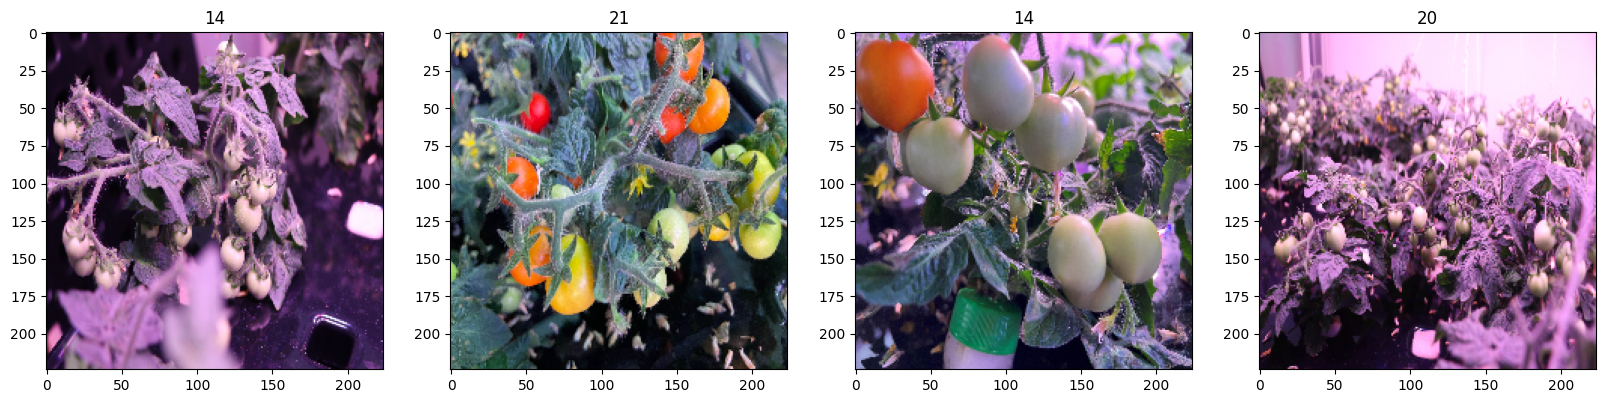

In [125]:
# Visually checking to see if batches are formed properly and we have augmented data in the batch
for batch in train_dataset:
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img)
        ax[idx].title.set_text(batch[1][idx].numpy())
    break    

<h2> Loading further dependencies

In [126]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,MaxPool2D
from keras import metrics

<h2> Builiding and Compiling the model

In [127]:
# Building the model
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3)))
model.add(MaxPool2D(2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

In [128]:
# Compiling the model with optimizer, loss function and target metrics
model.compile('adam', loss=tf.losses.MeanSquaredError(), metrics=metrics.MeanAbsoluteError())

In [129]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 186624)            0         
                                                                 
 dense_39 (Dense)            (None, 256)             

<h2> Training the model and validating

In [130]:
# Training the model
EPOCHS = 20
hist = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/20
35/35 [==============================] - 4s 96ms/step - loss: 121.9236 - mean_absolute_error: 7.6475 - val_loss: 67.5560 - val_mean_absolute_error: 6.5749
Epoch 2/20
35/35 [==============================] - 3s 71ms/step - loss: 73.8344 - mean_absolute_error: 6.0286 - val_loss: 52.8525 - val_mean_absolute_error: 5.3279
Epoch 3/20
35/35 [==============================] - 3s 70ms/step - loss: 53.9399 - mean_absolute_error: 5.2195 - val_loss: 72.6449 - val_mean_absolute_error: 5.4729
Epoch 4/20
35/35 [==============================] - 3s 70ms/step - loss: 51.7717 - mean_absolute_error: 5.2196 - val_loss: 57.5673 - val_mean_absolute_error: 5.2616
Epoch 5/20
35/35 [==============================] - 3s 68ms/step - loss: 45.4241 - mean_absolute_error: 4.7718 - val_loss: 26.0176 - val_mean_absolute_error: 3.9986
Epoch 6/20
35/35 [==============================] - 3s 69ms/step - loss: 26.7127 - mean_absolute_error: 3.7168 - val_loss: 21.3871 - val_mean_absolute_error: 3.6368
Epoch 7/2

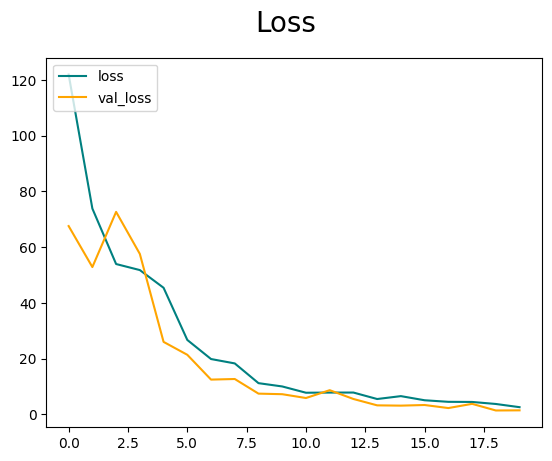

In [131]:
# Plotting training loss an validation loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

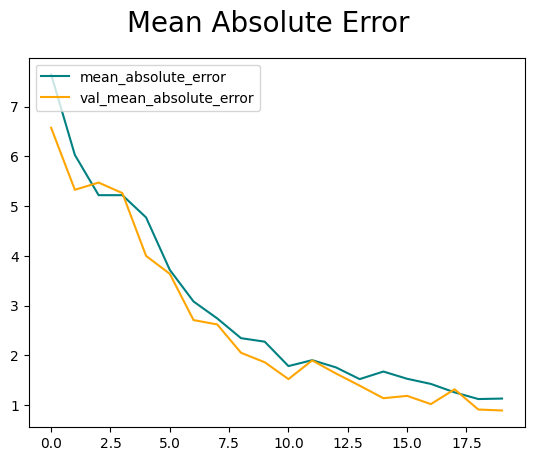

In [132]:
# Plotting training MAE an validation MAE
fig = plt.figure()
plt.plot(hist.history['mean_absolute_error'], color='teal', label='mean_absolute_error')
plt.plot(hist.history['val_mean_absolute_error'], color='orange', label='val_mean_absolute_error')
fig.suptitle('Mean Absolute Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h2> Evaluating the model on test data

In [133]:
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

mae = MeanAbsoluteError()
rmse = RootMeanSquaredError()

# This is to add all the y_true and y_pred in a single list from all the test batches
all_y_true = []
all_y_pred = []

for batch in test_dataset: 
    X, y_test = batch
    y_preds = model.predict(X)

    # Append true and predicted values to lists
    all_y_true.extend(y_test)
    all_y_pred.extend(y_preds)

    mae.update_state(y_test, y_preds)
    rmse.update_state(y_test, y_preds)

print('Mean Absolute Error',mae.result().numpy())
print('Root Mean Sqaured Error',rmse.result().numpy())

1/1 [==============================] - 0s 25ms/step
Mean Absolute Error 0.9757768
Root Mean Sqaured Error 1.4116031


<h3> Visualizing Model predictions

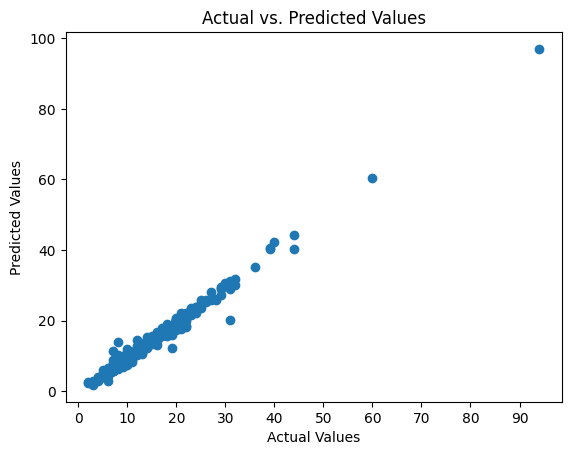

In [134]:
# Scatter plot
plt.scatter(all_y_true, all_y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xticks(range(0,max(all_y_true),10))
plt.title('Actual vs. Predicted Values')
plt.show()

1/1 [==============================] - 0s 45ms/step


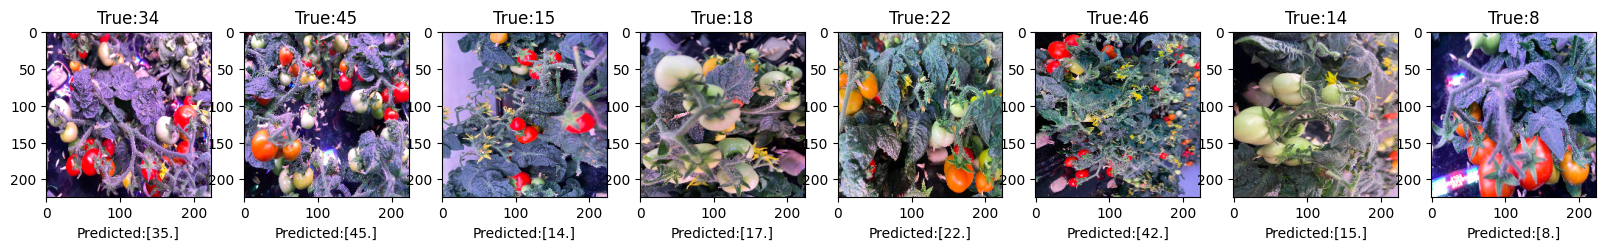

In [139]:
# Plot for model predictions on indivdual images
for batch in test_dataset: 
    X, y_test = batch
    y_preds = model.predict(X)

    fig, ax = plt.subplots(ncols=8, figsize=(20,20))
    for idx, img in enumerate(batch[0][:8]):
        ax[idx].imshow(img)
        ax[idx].title.set_text(f'True:{batch[1][idx].numpy()}')
        ax[idx].set_xlabel(f'Predicted:{np.rint(y_preds[idx])}') # rounds to nearest integer
    break 

<h2> Saving the model

In [136]:
model.save(os.path.join('models','tomato_counter.h5'))